In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import osmnx as ox
from us import states

In [2]:
# bounding_box = (-88.5,41,87.5,42.5)
bounding_box = None

In [3]:
lines_gdf=gpd.read_file("../data/transmission_lines/Electric__Power_Transmission_Lines/Electric__Power_Transmission_Lines.shp",
                        bbox=bounding_box)

In [4]:
illinois_url = states.IL.shapefile_urls()['county']
il_gdf = gpd.read_file(illinois_url,
                       bbox=bounding_box)

In [5]:
service_gdf = gpd.read_file("../data/spatial-data/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp",
                            bbox=bounding_box)

In [6]:
il_gdf.to_crs(epsg=4326, inplace=True)

# Transmission

In [7]:
il_lines = gpd.sjoin(lines_gdf, il_gdf, how='inner', predicate='intersects')

## Service

In [8]:
il_service = service_gdf[service_gdf['STATE']=='IL']

In [9]:
il_service = il_service.replace(dict(zip(il_service['CNTRL_AREA'].unique(), ['MISO-Z4','ComEd','EEI'])))

In [10]:
il_lines.VOLTAGE.value_counts()

VOLTAGE
 138.0       1414
 69.0        1078
 345.0        505
-999999.0     488
 161.0         76
 230.0         16
 765.0          5
Name: count, dtype: int64

In [11]:
il_lines.replace(-999999, np.nan, inplace=True)

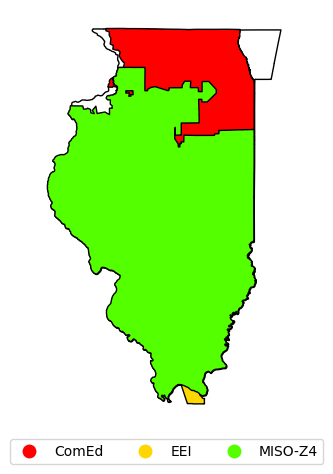

In [12]:
fig, ax = plt.subplots()
il_gdf.dissolve('STATEFP10').plot(ax=ax,facecolor='w',edgecolor='k')
il_service.dissolve("CNTRL_AREA").reset_index().plot(ax=ax, 
                column='CNTRL_AREA',
                categorical=True,
                cmap='prism',
                legend=True,
                legend_kwds=dict(loc=(-0.1, -0.1), ncols=3),
                alpha=1,
                edgecolor='k')
# il_lines.plot(ax=ax, edgecolor='r')
# il_lines.plot(ax=ax,
#               color='k'
            #    column='VOLTAGE', 
            #    categorical=False, 
            #    cmap='cividis',
            #    legend=True,
            #    legend_kwds=dict(label='Voltage [kV]')
            # )  
ax.set_axis_off()
plt.tight_layout()

In [13]:
il_lines[['ID','TYPE','VOLTAGE','SUB_1','SUB_2','geometry']].duplicated().sum()

653

In [14]:
il_lines_simple = il_lines[['ID','TYPE','VOLTAGE','SUB_1','SUB_2','geometry']]

In [15]:
n_lines = il_lines_simple.ID.value_counts()

In [16]:
n_lines.reset_index().sort_values(by='ID')['count']

1914    1
1807    1
1809    1
1830    1
1792    1
       ..
1208    1
1192    1
1212    1
1186    1
1206    1
Name: count, Length: 2929, dtype: int64

In [17]:
il_lines_unique = il_lines_simple[~il_lines_simple.duplicated()]

In [18]:
il_lines_unique = il_lines_unique.sort_values(by='ID').assign(n_lines=n_lines.reset_index().sort_values(by='ID')['count'].values)

In [19]:
from unyt import meter, mile

In [20]:
(2*meter).to(mile).to_value()

0.001242742408066988

In [21]:
line_lengths = il_lines_unique.to_crs(epsg=5070).length.apply(lambda d: (d*meter).to(mile).to_value())

In [22]:
il_lines_unique = il_lines_unique.assign(length = line_lengths.values)

In [23]:
il_lines_unique

,ID,TYPE,VOLTAGE,SUB_1,SUB_2,geometry,n_lines,length
14799,100062,AC; OVERHEAD,138.0,UNKNOWN122308,PROSPECT HEIGHTS,"LINESTRING (-87.91987 42.11519, -87.92066 42.1...",1,7.788602
17797,100147,AC; OVERHEAD,345.0,UNKNOWN122189,QUAD CITIES,"LINESTRING (-90.27894 41.71517, -90.27931 41.7...",1,2.179378
17861,100228,AC; OVERHEAD,138.0,UNKNOWN124430,TAP138216,"LINESTRING (-88.13106 41.56360, -88.13105 41.5...",1,5.057592
17879,100252,AC; OVERHEAD,138.0,UNKNOWN122309,PLEASANT HILL,"LINESTRING (-88.04330 41.85997, -88.04315 41.8...",1,8.086757
17919,100296,AC; OVERHEAD,138.0,UNKNOWN121940,UNKNOWN124710,"LINESTRING (-87.81741 42.38350, -87.81784 42.3...",1,12.238316
...,...,...,...,...,...,...,...,...
67113,180478,NOT AVAILABLE,NaN,UNKNOWN176493,UNKNOWN176035,"LINESTRING (-89.04503 39.90182, -89.04457 39.9...",1,0.081239
67729,180493,NOT AVAILABLE,NaN,UNKNOWN177326,TAP177241,"LINESTRING (-89.18322 38.28673, -89.18284 38.2...",1,2.077660
67368,180658,AC; OVERHEAD,69.0,SHERMAN,TAP176546,"LINESTRING (-89.63477 39.88161, -89.63513 39.8...",1,0.019472
67447,180663,NOT AVAILABLE,NaN,UNKNOWN157894,TAP176072,"LINESTRING (-88.81802 39.40086, -88.81801 39.4...",1,0.162990


In [24]:
sub_1_coords = il_lines.geometry.apply(lambda x: x.boundary.geoms[0])
sub_2_coords = il_lines.geometry.apply(lambda x: x.boundary.geoms[1])

In [25]:
sub_1_coords.values[0].x

-88.2350718

In [26]:
import pypsa

In [27]:
# for index, row in il_lines.iterrows():
#     voltage = row['VOLTAGE']
#     sub_1_coords = 
#     print(row['SUB_1'])